# Resampling Data

I have ALMA Data set, with a angular spectral 14", that I need resampling to 16" (angular resolution spectral in SOFIA - Y. Okada - )

Resampling spectral resolution is the first step, because it is independent of the spatial axis, it reduces the error to reduce the number of channels and avoid loss of information.

_Is important generate a change of frequency to velocity, previous to resampling_

 __FREQ TO RADIAL VELOCITY__

To convert Frequency to Velocity, in radio astronomy it is necessary to know that, the ALMA data deliver a _Resting Frequency_, which refers to the intrinsic frequency where the spectral line emitted in the emitter reference systems, before some relative motion effect, such as __Doppler effect__ (redshift).

Doppler Effect
$$ v = c (\frac{\lambda_{rest} - \lambda}{\lambda_{rest}})$$

where: 
- $\lambda_{rest}$ : Rest Freq. (Hz)
- $\lambda$ : Freq. (Hz)
- c : Light velocity (km/s)
- v : velocity (km/s)

Python have a equivalencies for this; _using {doopler_radio()}_

**NOTE:
Each axis in the data file contains three parameters to extract: __CRVAL__ ,__CDET__ y__CRPIX__. Do I extract all information about each channel, I applied an extraction format given by: 
$$Y = (X - X_0)m + b$$
$$AX = CRVAL + (i - CRPIX) * CDELT$$

and $i$ is the channel number, in case of frequency is between (1 - 2043)

where: 
- CRVAL: El valor de referencia del eje (frecuencia de referencia en este caso en el primer pixel).
- CDELT: El incremento en el valor de la coordenada fisica entre los pixeles consecutivos.
- CRPIX: El indice del pixel de referencia (indice donde se encuentra el valor de referencia)
- NAXIS: Numero total de canales en el eje




In [1]:
import numpy as np
from astropy.io import fits

from astropy.wcs import WCS
from spectral_cube import SpectralCube
from astropy import units as u

#Load the data
hdul = fits.open("member.uid___A001_X3621_X1a6a.N159-13CII_sci.spw26.cube.I.pbcor.fits")

hdu = hdul[0]
data = hdu.data
header = hdu.header
wcs = WCS(header)


##Starting the conversion From Frequency to Velocity
#Extract the necessesary information
RESTFREQ = header["RESTFRQ"] * u.Hz #applied into Doppler effect
print(RESTFREQ)
CRVAL_3 = header["CRVAL3"]
CRPIX_3 = header["CRPIX3"]
CDELT_3 = header["CDELT3"]
NAXIS_3 = header["NAXIS3"]

#Calculate the frequency of each channel (Hz)
CH = np.arange(1, NAXIS_3 + 1) #generates an array of integers ranging from 1 to NAXIS_3 [1,2,3,...,NAXIS_3]
FREQ_AX = ((CH - CRPIX_3) * CDELT_3 + CRVAL_3) * u.Hz #Calculates the frequency of each channel
#print(FREQ_AX)
VEL = FREQ_AX.to(u.km / u.s, equivalencies=u.doppler_radio(RESTFREQ)) #converts the frequency to velocity
print(VEL[:10])


102587476000.0 Hz
[599.07055662 598.71379102 598.35702542 598.00025982 597.64349422
 597.28672862 596.92996301 596.57319741 596.21643181 595.85966621] km / s


In [ ]:
#Save the data to a new FITS file, with the new velocity axis and the same data
#Create a new header with the new velocity axis
new_header = header.copy()


### I do reampling spectral resolution first, to 1 [$\frac{km}{s}$].
 _This adjust is necessary, because the yoko data have this resolution_

To do this, is necessary interpolar the datas and convolution (if is necessary)
*Note:* The velocity isn't integers numbres, so is necessary changes the values from decimals to integers.

For this purpose, the axis is set to integers with an interpolation.

In [19]:
####### Resampling the spectral resolution 

# Define new spectral resolution at 1 km/s
SPECTRAL_RE = 1 * u.km / u.s

# Create a new spectral axis with wish resolution
##Apply the round up the min and max values.
VEL_min = np.floor(VEL.min().value) #round down the min value
VEL_max = np.ceil(VEL.max().value) #round up the max value
#print(VEL_min, VEL_max)

# Create a new spectral axis with the desired resolution
#np.arange(start, stop, step) -> array of evenly spaced values (step value)
new_spectral_axis = np.arange(VEL_min, VEL_max + 1, SPECTRAL_RE.value) * u.km / u.s
#print(new_spectral_axis)

# Interpolar el cubo al nuevo eje espectral
#NaN = np.nan  #evitar error en la interpolación con los datos nan (lugare vacios)
resampled_cube = CUBE.spectral_interpolate(new_spectral_axis)
#print(resampled_cube.header['CDELT3'])
#print(resampled_cube.shape)


Spectral Interpolate:   0%|          | 0/15360 [00:00<?, ?it/s]

In [ ]:
resampled_vel_axis = resampled_cube.spectral_axis.to (u.km / u.s) 
print (resampled_cube)

SpectralCube with shape=(731, 128, 120) and unit=Jy / beam:
 n_x:    120  type_x: RA---SIN  unit_x: deg    range:    84.794668 deg:   85.014927 deg
 n_y:    128  type_y: DEC--SIN  unit_y: deg    range:   -69.807597 deg:  -69.726457 deg
 n_s:    731  type_s: VRAD      unit_s: km / s  range:     -130.000 km / s:     600.000 km / s


In [ ]:
###Save the resampled cube to a new FITS file
# Create a new FITS file with the resampled data
resampled_cube.write("CUBE_SPEC_RESAM.fits", overwrite=True, use_dask=True)

#print("Resampled cube saved to CUBE_SPEC_RESAM.fits")

### Close the original FITS file
hdul.close()

### Close the resampled FITS file
resampled_cube = None

Resampled cube saved to CUBE_SPEC_RESAM.fits


## SANITY CHECK

Is necessary, check the datas is correct. 
For this purpouse, generate a intensity graph, with three axis: AX-x = Vlsr and FREQ, AX-y = Jy/beam. 

*NOTE:* 
- item the intensity is the sum of all data
- item is necessary to fix the range of velocity 
- item check the velocity of rest frequency 

remember that:

$$ V_i = CRVAL + CRDEL (i - CRPIX) $$


In [1]:
###Calculation of the integrated intensity of original and resampled cubes

import numpy as np
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt

#Load the data cubes
CUBE_Orig = SpectralCube.read("member.uid___A001_X3621_X1a6a.N159-13CII_sci.spw26.cube.I.pbcor.fits", format='fits', use_dask=True)
CUBE_VELResam = SpectralCube.read("CUBE_SPEC_RESAM.fits", format='fits', use_dask=True)

#print(CUBE_VELResam)
#print(CUBE_Orig)

#Define the rest frequency
header = CUBE_Orig.header
RESTFREQ = header["RESTFRQ"] * u.Hz #applied into Doppler effect
#print(RESTFREQ)

Statistic = CUBE_Orig.statistics() #Statistics of the resampled cube
print(Statistic)

{'npts': np.float64(14989491.0), 'min': <Quantity -0.1138537 Jy / beam>, 'max': <Quantity 0.11928345 Jy / beam>, 'sum': <Quantity -72.60558319 Jy / beam>, 'sumsq': <Quantity 2259.77270508 Jy2 / beam2>, 'mean': <Quantity -4.84376576e-06 Jy / beam>, 'sigma': <Quantity 0.01227832 Jy / beam>, 'rms': <Quantity 0.01227832 Jy / beam>}


In [9]:
###Define the axis
##From the original cube extract the frequency axis and the velocity axis

FREQ_Orig = CUBE_Orig.spectral_axis.to(u.Hz) #SpectralCube, it already interprets the formula automatically when constructing the axis
VEL_Orig = FREQ_Orig.to(u.km / u.s, equivalencies=u.doppler_radio(RESTFREQ)) #converts the frequency to velocity

#print(VEL_Orig[:10])
#print(FREQ_Orig[:10])


##From the resampled cube extract the velocity axis
VEL_SpecResam = CUBE_VELResam.spectral_axis.to(u.km / u.s) #converts the frequency to velocity

#print(VEL_SpecResam[:10])

# Convert the spectral axis of the cubes to velocity units
CUBE_Orig_Vel = CUBE_Orig.with_spectral_unit(u.km / u.s, velocity_convention='radio', rest_value=RESTFREQ)
CUBE_VELResam_Vel = CUBE_VELResam.with_spectral_unit(u.km / u.s, velocity_convention='radio', rest_value=RESTFREQ)

##Define a range of velocitys to integrate over
vmin = 200 * u.km / u.s
vmax = 250 * u.km / u.s

#Creation of booleans masks to select the pixels that are within the range of velocities
Range_Orig = (VEL_Orig >= vmin) & (VEL_Orig <= vmax) #mask of the original cube
Range_Resam = (VEL_SpecResam >= vmin) & (VEL_SpecResam <= vmax) #mask of the resampled cube

#Reduce the cube to the selected velocity range
CUBE_Orig_Range = CUBE_Orig_Vel.spectral_slab(vmin, vmax) #original cube
CUBE_VELResam_Range = CUBE_VELResam_Vel.spectral_slab(vmin, vmax) #resampled cube


#Integrate intensity over the two space axis (Jy/beam)
INTENS_Orig = CUBE_Orig.sum(axis=(1, 2)) #mean en RA and DEC
INTENS_SpecResam = CUBE_VELResam.sum(axis=(1, 2)) #mean en RA and DEC

# Apply mask based on threshold
#mask_Orig = INTENS_Orig > umbral  # mask for the original cube
#mask_Resam = INTENS_SpecResam > umbral  # mask for the resampled cube

#Generate the X - Axis
VEL_RES = VEL_SpecResam[Range_Resam] #velocity axis of the resampled cube
FREQ_RES = VEL_RES.to(u.Hz, equivalencies=u.doppler_radio(RESTFREQ)) #frequency axis of the resampled cube
#print(FREQ_RES[:10])
#print(VEL_RES[:10])


In [10]:
print("Canales originales seleccionados:", np.sum(Range_Orig))
print("Canales remuestreados seleccionados:", np.sum(Range_Resam))

Canales originales seleccionados: 140
Canales remuestreados seleccionados: 51


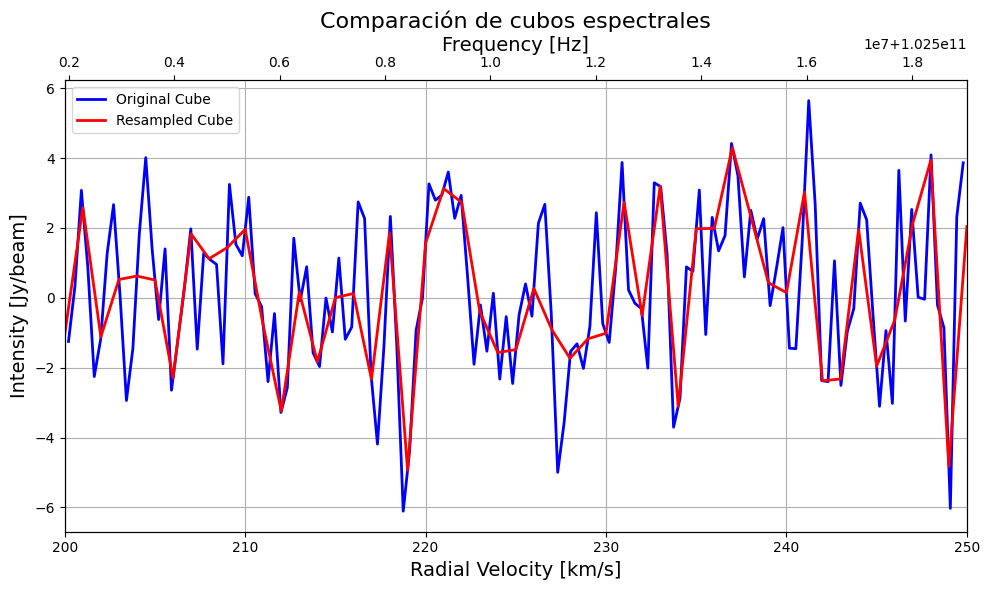

In [11]:
### Creation of the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

#Down X-Axis
ax1.plot(VEL_Orig[Range_Orig], INTENS_Orig[Range_Orig], label='Original Cube', lw=2, color='blue')
ax1.plot(VEL_RES, INTENS_SpecResam[Range_Resam], label='Resampled Cube', lw=2, color='red')

ax1.set_xlabel('Radial Velocity [km/s]', fontsize=14)
ax1.set_ylabel('Intensity [Jy/beam]', fontsize=14)
ax1.set_xlim(vmin.value, vmax.value)
ax1.legend()
ax1.grid(True)

ax1.set_title('Comparación de cubos espectrales', fontsize=16)


#Up X-Axis
ax2 = ax1.twiny()
ax2.set_xlim(FREQ_RES.min().value, FREQ_RES.max().value)
ax2.set_xlabel('Frequency [Hz]', fontsize=14)

plt.tight_layout()
plt.show()

In [5]:
###PROFE'S CODE

sub_cube = sub_cube.with_spectral_unit(u.Angstrom, velocity_convention='optical', rest_value=line_wave * u.Angstrom)
#
import scipy
import scipy.constants       as sc
from   scipy                 import constants
from   scipy                 import stats # collection of mathematical algorithms and convenience functions built on the NumPy extension of Python
from   scipy.optimize        import curve_fit # provides functions for minimizing (or maximizing) objective functions, possibly subject to constraints. It includes solvers for nonlinear problems (with support for both local and global optimization algorithms), linear programing, constrained and nonlinear least-squares, root finding, and curve fitting.
from   scipy.optimize        import minimize # functions for minimizing (or maximizing) objective functions, possibly subject to constraints
from   scipy.optimize        import fsolve # Find the roots of a function.
from   scipy.stats           import gaussian_kde # for density plots

# flux density units are not recognized by SpectralCube, so they have to be defined
u.add_enabled_units(u.def_unit(['ergs/s/cm^2/A'], represents=u.erg / u.s /u.cm**2 / u.Angstrom)) 
u.add_enabled_units(u.def_unit(['K (Tmb)'], represents=u.Kelvin))
u.add_enabled_units(u.def_unit(['K (Ta*)'], represents=u.Kelvin))


###Esto es para Jy/beam a K?

NameError: name 'sub_cube' is not defined

In [ ]:
print(resampled_cube.header['CDELT3'])
print(resampled_cube.header)
# Guardar el cubo resampleado en un nuevo archivo FITS
#resampled_cube.write("CUBE_RESAMPLED_SPECTRAL.fits", overwrite=True)


1.0
SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    3                                                  NAXIS1  =                  120                                                  NAXIS2  =                  128                                                  NAXIS3  =                  729                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   4.442253420057E-03                                                  BMIN    =   3.226777089219E-03                                                  BPA     =  -8.550686982140E+01                                                  BTYPE   = 'Intensity'               

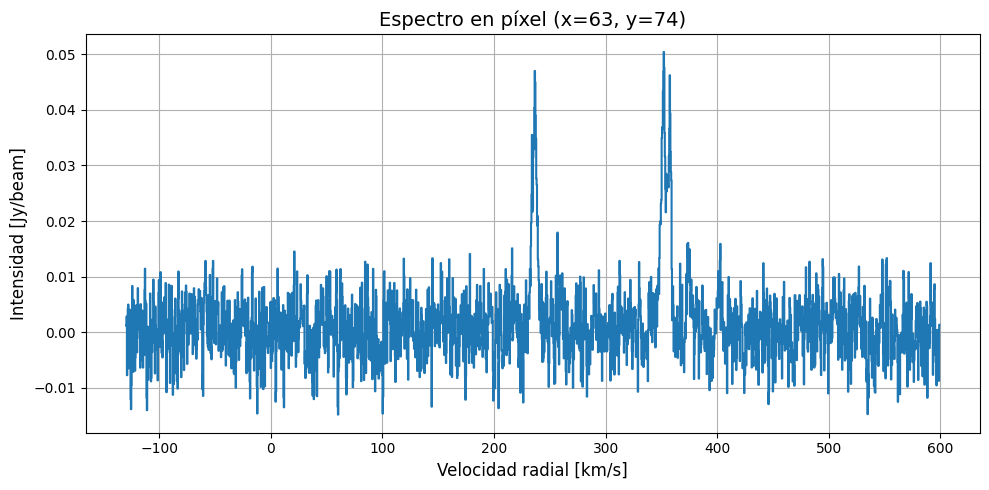

In [ ]:
##### View a spectrum before of resampling
import numpy as np
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
import astropy.units as u

# Cargar el cubo (reemplaza con el nombre de tu archivo)
cube = SpectralCube.read("member.uid___A001_X3621_X1a6a.N159-13CII_sci.spw26.cube.I.pbcor.fits", format='fits', use_dask=True)

# Convertimos el eje espectral a velocidad radial usando la frecuencia de reposo
rest_freq = cube.header['RESTFRQ'] * u.Hz

# Convertir el cubo a eje espectral en velocidades radiales (LSRK, convención radio)
cube_vel = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=rest_freq) #para ver el cubo en km/s
cube_freq = cube.with_spectral_unit(u.Hz)

#--------------------Espectro en un píxel ---------------------------
# Selecciona las coordenadas (x, y) en píxeles
x_pixel = 63  # RA
y_pixel = 74  # DEC

# Extrae el espectro del píxel (esto da un array 1D a lo largo del eje espectral)
spectrum_pixel = cube_vel[:, y_pixel, x_pixel]

# Obtener el eje de velocidades
vel_axis = cube_vel.spectral_axis
freq_axis = cube_freq.spectral_axis

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(vel_axis, spectrum_pixel, drawstyle='steps-mid')
#plt.plot(freq_axis, spectrum_avg, drawstyle='steps-mid', color='blue')
plt.xlabel("Velocidad radial [km/s]", fontsize=12)
#plt.xlabel("Frecuencia [Hz]", fontsize=12)
plt.ylabel("Intensidad [Jy/beam]", fontsize=12)
plt.title(f"Espectro en píxel (x={x_pixel}, y={y_pixel})", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

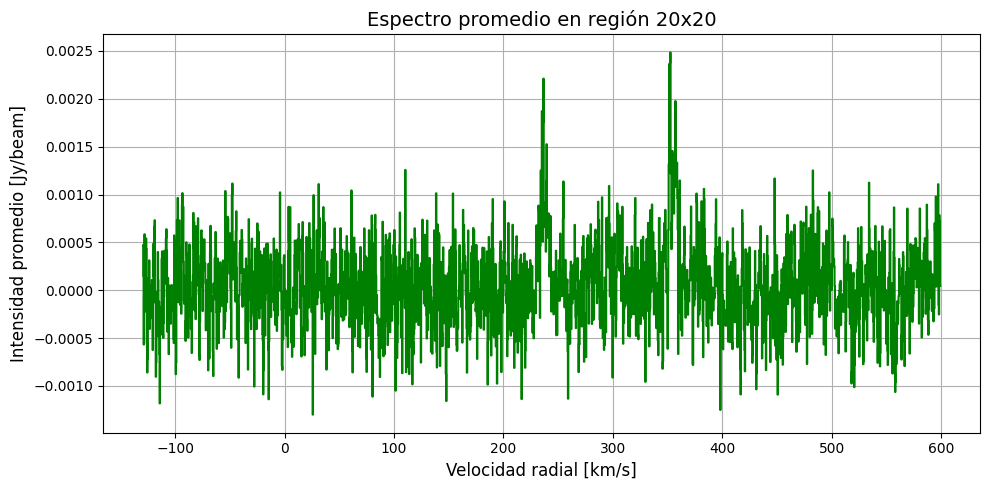

In [ ]:
# Puedes definir un recorte espacial del cubo
subcube = cube_vel[:, 52:82, 52:82]  # por ejemplo, un cuadrado 10x10 píxeles

# Calcular el espectro promedio sobre esa región
spectrum_avg = subcube.mean(axis=(1, 2))  # promedio sobre RA y DEC

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(vel_axis, spectrum_avg, drawstyle='steps-mid', color='green')
#plt.plot(freq_axis, spectrum_avg, drawstyle='steps-mid', color='green')
#plt.xlabel("Frecuencia [Hz]", fontsize=12)
plt.xlabel("Velocidad radial [km/s]", fontsize=12)
plt.ylabel("Intensidad promedio [Jy/beam]", fontsize=12)
plt.title("Espectro promedio en región 20x20", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

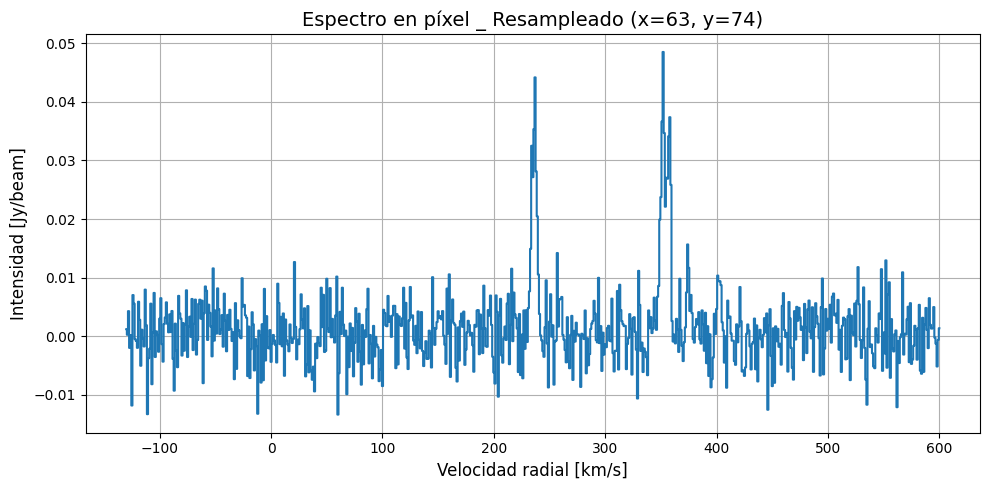

In [ ]:
##### View a spectrum after of resampling
import numpy as np
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
import astropy.units as u

# Cargar el cubo (reemplaza con el nombre de tu archivo)
cube2 = SpectralCube.read("CUBE_SPEC_RESAM.fits", format='fits', use_dask=True)

# Convertimos el eje espectral a velocidad radial usando la frecuencia de reposo
rest2_freq = cube2.header['RESTFRQ'] * u.Hz

# Convertir el cubo a eje espectral en velocidades radiales (LSRK, convención radio)
cube2_vel = cube2.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=rest2_freq) #para ver el cubo en km/s
cube2_freq = cube2.with_spectral_unit(u.Hz)

#--------------------Espectro en un píxel ---------------------------
# Selecciona las coordenadas (x, y) en píxeles
x2_pixel = 63  # RA
y2_pixel = 74  # DEC

# Extrae el espectro del píxel (esto da un array 1D a lo largo del eje espectral)
spectrum2_pixel = cube2_vel[:, y2_pixel, x2_pixel]

# Obtener el eje de velocidades
vel2_axis = cube2_vel.spectral_axis
freq2_axis = cube2_freq.spectral_axis

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(vel2_axis, spectrum2_pixel, drawstyle='steps-mid')
#plt.plot(freq_axis, spectrum_avg, drawstyle='steps-mid', color='green')
plt.xlabel("Velocidad radial [km/s]", fontsize=12)
#plt.xlabel("Frecuencia [Hz]", fontsize=12)
plt.ylabel("Intensidad [Jy/beam]", fontsize=12)
plt.title(f"Espectro en píxel _ Resampleado (x={x_pixel}, y={y_pixel})", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

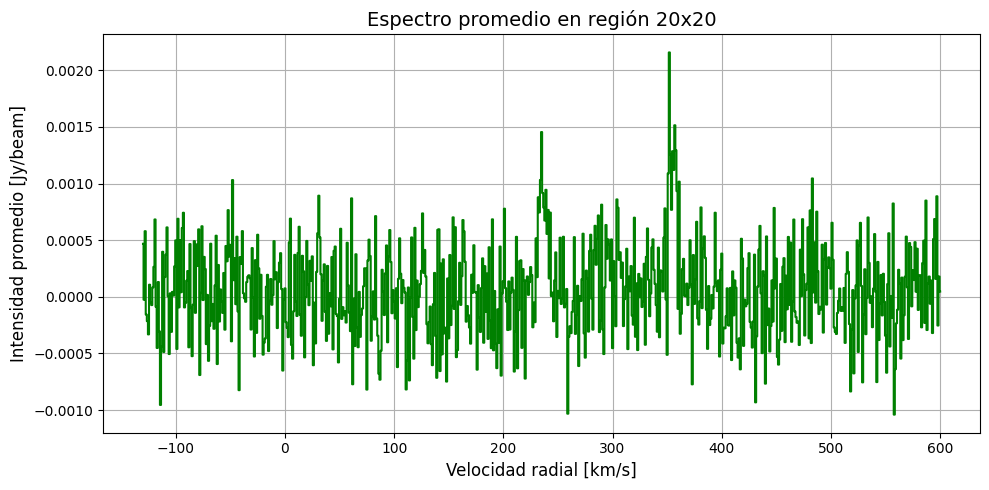

In [ ]:
# Puedes definir un recorte espacial del cubo
subcube2 = cube2_vel[:, 52:82, 52:82]  # por ejemplo, un cuadrado 10x10 píxeles

# Calcular el espectro promedio sobre esa región
spectrum2_avg = subcube2.mean(axis=(1, 2))  # promedio sobre RA y DEC

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(vel2_axis, spectrum2_avg, drawstyle='steps-mid', color='green')
#plt.plot(freq_axis, spectrum_avg, drawstyle='steps-mid', color='green')
#plt.xlabel("Frecuencia [Hz]", fontsize=12)
plt.xlabel("Velocidad radial [km/s]", fontsize=12)
plt.ylabel("Intensidad promedio [Jy/beam]", fontsize=12)
plt.title("Espectro promedio en región 20x20", fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()